In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, hamming_loss
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
!pip install yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
url = 'https://raw.githubusercontent.com/denn2900/DM_Group/refs/heads/main/Asignmentpart1_Dataset_section7.csv'
df = pd.read_csv(url)

# Classification

Feature Selection

In [ ]:
df_classification = df.copy()

demographic_cols = ["Age", "Sex", "Race"]
substance_cols = ["Any_Opioid","Heroin", "Cocaine", "Fentanyl", "Fentanyl_Analogue", "Oxycodone", "Oxymorphone",
                  "Ethanol", "Hydrocodone", "Benzodiazepine", "Methadone", "Meth/Amphetamine",
                  "Amphet", "Tramad", "Hydromorphone", "Morphine_(Not_Heroin)", "Xylazine",
                  "Gabapentin", "Opiate_NOS", "Heroin/Morph/Codeine", "Other_Opioid"]
geographical_cols = ["Residence_City", "Residence_County" , "Residence_State", "Injury_City", "Injury_County" , "Injury_State", "Death_City", "Death_County" , "Death_State"]


Data Preprocessing

In [ ]:
categorical_features = ["Sex", "Race", "Residence_City", "Residence_County" , "Residence_State","Injury_City", "Injury_County" , "Injury_State", "Death_City", "Death_County" , "Death_State"]
label_encoders = {}
for col in categorical_features:
   le = LabelEncoder()
   df_classification[col] = le.fit_transform(df_classification[col])
   label_encoders[col] = le

for col in substance_cols:
    if df_classification[col].dtype == "object":
       df_classification[col] = df_classification[col].apply(lambda x: 1 if x == "Yes" else 0)


X = df_classification[demographic_cols + geographical_cols]
y = df_classification[substance_cols]

Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Size of Training set (70%)", X_train.shape)
print("Size of Test set (30%)", X_test.shape)

Size of Training set (70%) (8385, 12)
Size of Test set (30%) (3594, 12)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building Classification Model

In [ ]:
rf_params = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [10, 15, 20],
    'estimator__min_samples_split': [2, 5, 10],
}

multi_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_grid = GridSearchCV(multi_rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [10, 15, 20],
                         'estimator__min_samples_split': [2, 5, 10],
                         'estimator__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
best_rf = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

Best Random Forest Parameters: {'estimator__max_depth': 15, 'estimator__min_samples_split': 10, 'estimator__n_estimators': 50}


Model Evaluation

In [ ]:
y_pred = best_rf.predict(X_test_scaled)

In [ ]:
metrics = {
    "Accuracy": accuracy_score,
    "Hamming Loss": hamming_loss,
    "F1 Micro": lambda y_true, y_pred: f1_score(y_true, y_pred, average="micro"),
    "F1 Macro": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    "F1 Weighted": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="micro", zero_division=0),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="micro", zero_division=0)
}
average_metrics = {metric: np.mean([func(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])])
                   for metric, func in metrics.items()}

for metric, value in average_metrics.items():
    print(f" {metric}: {value:.4f}")

 Accuracy: 0.8875
 Hamming Loss: 0.1125
 F1 Micro: 0.8875
 F1 Macro: 0.5365
 F1 Weighted: 0.8598
 Precision: 0.8875
 Recall: 0.8875


Visualization

In [ ]:
metrics_df = pd.DataFrame({
    "Substance": substance_cols,
    **{metric: [func(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])] for metric, func in metrics.items()}
})

<ipython-input-23-e8af397dd6b9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="coolwarm")


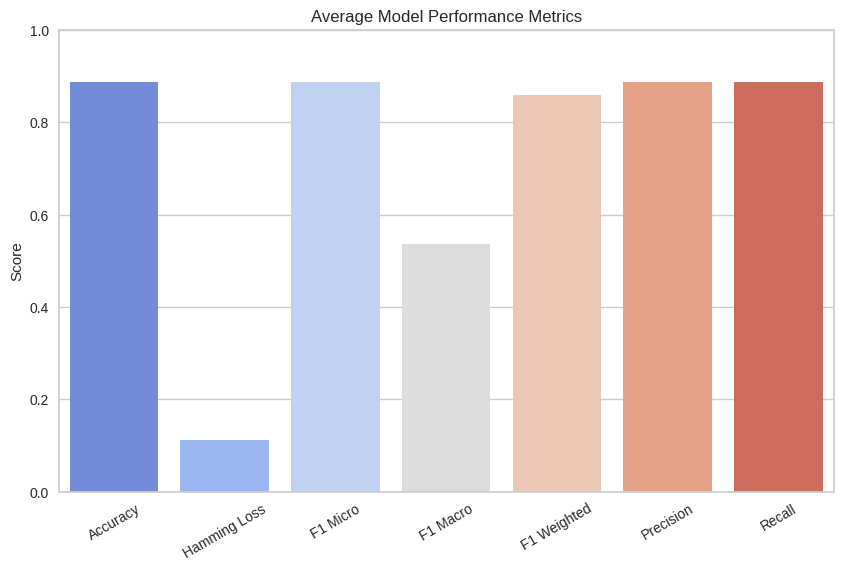

In [ ]:
metrics_df_mean = metrics_df.mean(numeric_only=True)
metric_names = metrics_df_mean.index.tolist()
metric_values = metrics_df_mean.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x=metric_names, y=metric_values, palette="coolwarm")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Average Model Performance Metrics")
plt.xticks(rotation=30)
plt.show()

<ipython-input-25-73a22f1aacdc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="Substance", y="Accuracy", palette="viridis")


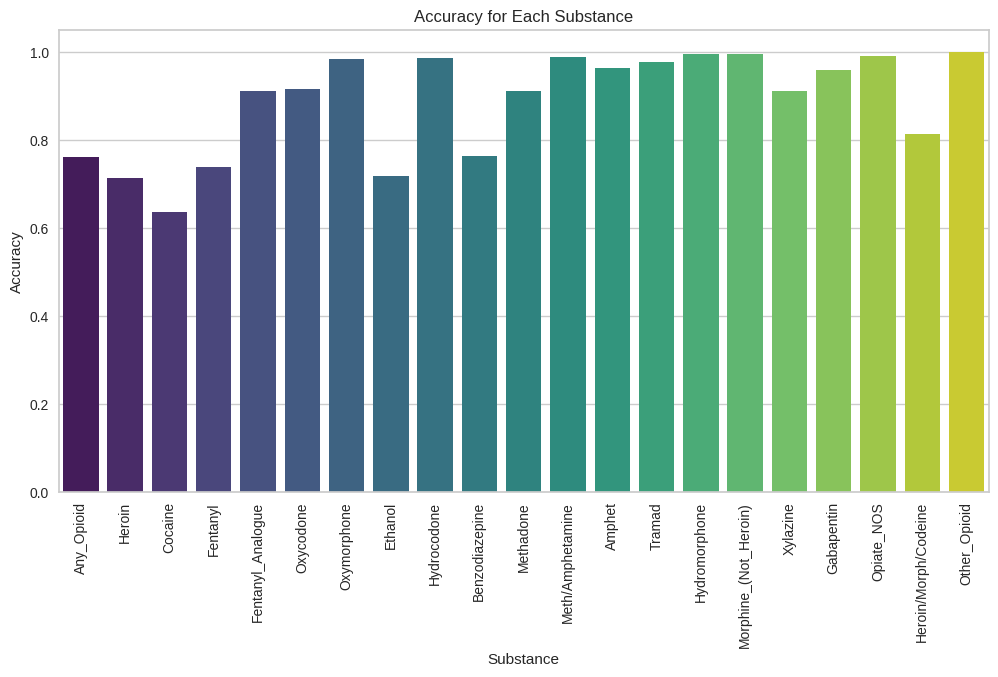

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="Substance", y="Accuracy", palette="viridis")
plt.xticks(rotation=90)
plt.title("Accuracy for Each Substance")
plt.ylabel("Accuracy")
plt.xlabel("Substance")
plt.show()

<ipython-input-29-df7348dbcf3e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=np.array(feature_names)[sorted_idx], x=feature_importances[sorted_idx], palette="rocket_r")


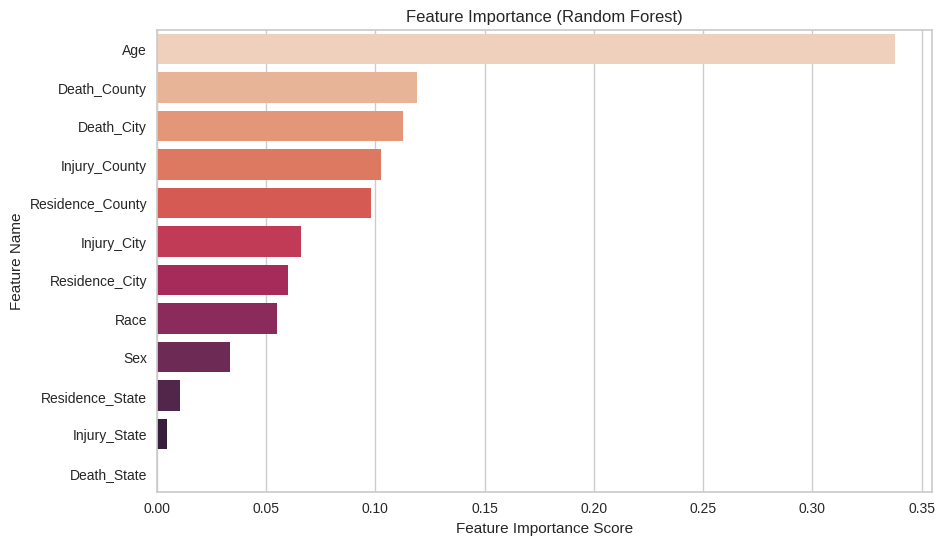

In [ ]:
feature_importances = best_rf.estimators_[0].feature_importances_  # Extract from first estimator
feature_names = X.columns

sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(y=np.array(feature_names)[sorted_idx], x=feature_importances[sorted_idx], palette="rocket_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Random Forest)")
plt.show()

# Clustering

Data Preprocessing

In [ ]:
df_clustering = df.copy()

# Convert 'Yes'/'No' to binary (1/0)
drug_cols = ["Fentanyl", "Cocaine", "Heroin", "Ethanol"]
df_clustering[drug_cols] = df_clustering[drug_cols].replace({'Yes': 1, 'No': 0})

# Select relevant columns
columns = ["Age", "ICG_latitude", "ICG_longitude"] + drug_cols
df_clustering = df_clustering[columns].copy()

# Drop rows with missing latitude/longitude
df_clustering.dropna(subset=["ICG_latitude", "ICG_longitude"], inplace=True)

# Convert all columns to numeric, forcing non-numeric values to NaN
df_clustering = df_clustering.apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN values in essential columns
df_clustering.dropna(subset=["Age", "ICG_latitude", "ICG_longitude"], inplace=True)

# Impute missing values for Age using the median
imputer = SimpleImputer(strategy="median")
df_clustering["Age"] = imputer.fit_transform(df_clustering[["Age"]])

# Fill missing drug values with 0 (assuming missing means no presence)
df_clustering[drug_cols] = df_clustering[drug_cols].fillna(0)
#Combined DBSCAN Clustering (Location & Drug Usage)
features = ["Age", "ICG_latitude", "ICG_longitude"] + drug_cols
X = df_clustering[features]

# Convert all columns in X to numeric, replacing non-numeric values with NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Assuming df_clustering is your DataFrame with features for clustering
features = ["Age", "ICG_latitude", "ICG_longitude", "Fentanyl", "Cocaine", "Heroin", "Ethanol"]
X = df_clustering[features]

# Scale the features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

<ipython-input-2-24719c997ff6>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clustering[drug_cols] = df_clustering[drug_cols].replace({'Yes': 1, 'No': 0})


Model Building

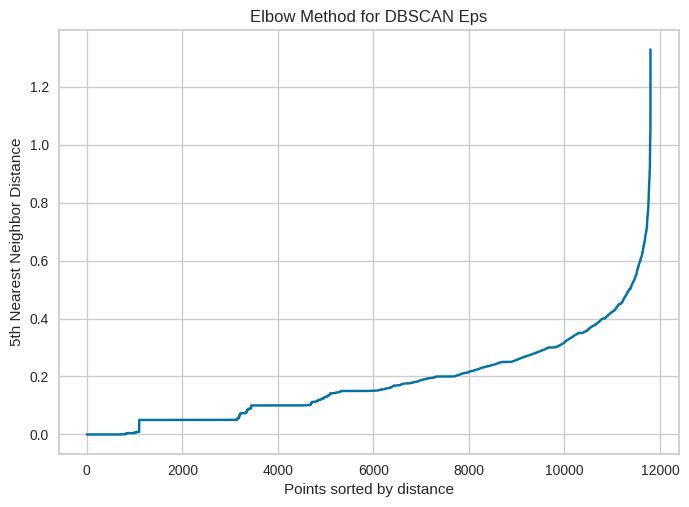

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for DBSCAN Eps")
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=30)
df_clustering["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled)

Model Evaluation

In [ ]:
valid_clusters = df_clustering["DBSCAN_Cluster"] != -1
if valid_clusters.sum() > 1:
    silhouette = silhouette_score(X_scaled[valid_clusters], df_clustering["DBSCAN_Cluster"][valid_clusters])
    db_index = davies_bouldin_score(X_scaled[valid_clusters], df_clustering["DBSCAN_Cluster"][valid_clusters])
    print(f"DBSCAN Clustering - Silhouette Score: {silhouette:.4f}")
    print(f"DBSCAN Clustering - Davies-Bouldin Index: {db_index:.4f}")

DBSCAN Clustering - Silhouette Score: 0.4156
DBSCAN Clustering - Davies-Bouldin Index: 0.8556


In [ ]:
print(df_clustering["DBSCAN_Cluster"].value_counts())

DBSCAN_Cluster
-1     9376
 0      514
 1      467
 4      249
 6      193
 5      179
 7      158
 2      101
 3       93
 11      77
 13      72
 10      56
 12      51
 8       37
 9       34
 17      33
 15      31
 16      30
 14      30
 18      20
Name: count, dtype: int64


Visualization

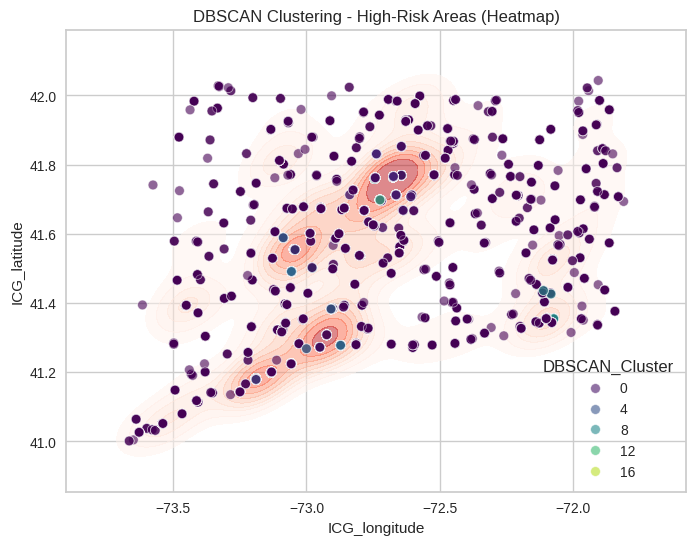

In [ ]:
plt.figure(figsize=(8,6))
sns.kdeplot(x=df_clustering["ICG_longitude"],
            y=df_clustering["ICG_latitude"],
            fill=True, cmap="Reds", alpha=0.5)
sns.scatterplot(x=df_clustering["ICG_longitude"],
                y=df_clustering["ICG_latitude"],
                hue=df_clustering["DBSCAN_Cluster"], palette="viridis", alpha=0.6)

plt.xlabel("ICG_longitude")
plt.ylabel("ICG_latitude")
plt.title("DBSCAN Clustering - High-Risk Areas (Heatmap)")
plt.show()

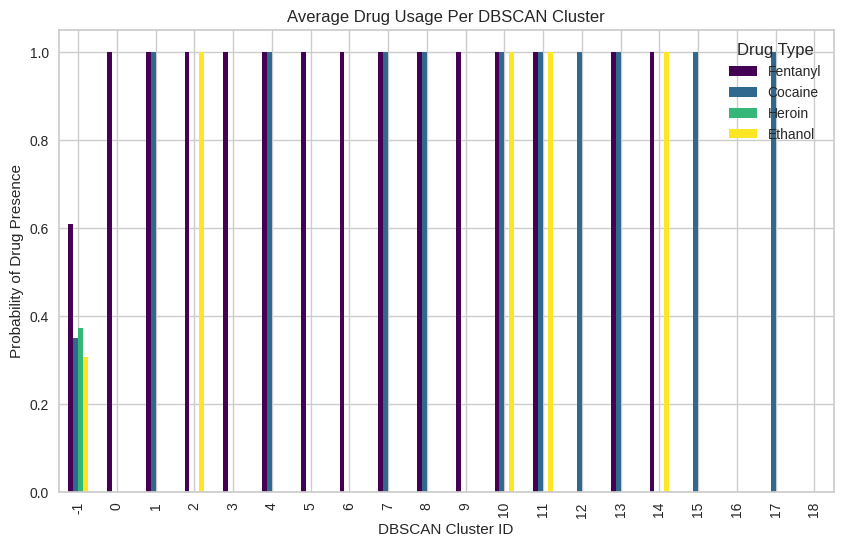

In [ ]:
# Compute average drug usage per cluster
cluster_drug_usage = df_clustering.groupby("DBSCAN_Cluster")[drug_cols].mean()

# Visualize drug distribution per cluster
cluster_drug_usage.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Average Drug Usage Per DBSCAN Cluster")
plt.ylabel("Probability of Drug Presence")
plt.xlabel("DBSCAN Cluster ID")
plt.legend(title="Drug Type")
plt.show()

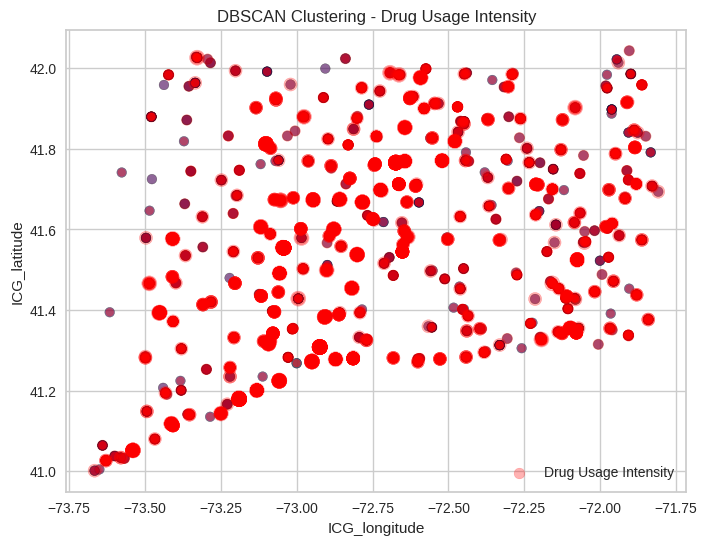

In [ ]:
# Display clustering results with drug usage intensity overlay
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_clustering["ICG_longitude"], df_clustering["ICG_latitude"],
                      c=df_clustering["DBSCAN_Cluster"], cmap="viridis", alpha=0.6, edgecolors="k")

size_factor = df_clustering[drug_cols].sum(axis=1) * 30  # Adjust point size
plt.scatter(df_clustering["ICG_longitude"], df_clustering["ICG_latitude"],
            s=size_factor, color="red", alpha=0.3, label="Drug Usage Intensity")

plt.xlabel("ICG_longitude")
plt.ylabel("ICG_latitude")
plt.title("DBSCAN Clustering - Drug Usage Intensity")
plt.legend()
plt.show()

# Outlier Detection

Data Preprocessing

In [ ]:
# Select numeric features for outlier detection
numeric_cols = ['Age', 'RCG_latitude', 'RCG_longitude', 'ICG_latitude', 'ICG_longitude', 'DCG_latitude', 'DCG_longitude']
df_numeric = df[numeric_cols].copy()

# Handle missing values
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Encode categorical features
categorical_cols = [
    'Sex', 'Race', 'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'Ethanol', 'Hydrocodone',
    'Benzodiazepine', 'Methadone', 'Meth/Amphetamine', 'Amphet', 'Tramad',
    'Hydromorphone', 'Morphine_(Not_Heroin)', 'Xylazine', 'Gabapentin',
    'Opiate_NOS', 'Heroin/Morph/Codeine', 'Other_Opioid', 'Any_Opioid'
]
df_categorical = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

# Combine numeric and categorical data
df_processed = pd.concat([df_numeric, df_categorical], axis=1)

Outlier Detection

In [ ]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_processed['Anomaly_IF'] = iso_forest.fit_predict(df_processed)

df_processed['Anomaly_IF_Binary'] = df_processed['Anomaly_IF'].apply(lambda x: 1 if x == -1 else 0)

# Z-score
threshold = 3.0
df_processed['Z_Score'] = df_numeric.apply(zscore).abs().max(axis=1)
df_processed['Anomaly_Z'] = df_processed['Z_Score'] > threshold
df_processed['Anomaly_Z_Binary'] = df_processed['Anomaly_Z'].astype(int)

print(df_processed[['Anomaly_IF_Binary', 'Anomaly_Z_Binary']].value_counts())

Anomaly_IF_Binary  Anomaly_Z_Binary
0                  0                   11347
1                  0                     591
0                  1                      33
1                  1                       8
Name: count, dtype: int64


Model Evaluation

In [ ]:
# Define ground truth proxy for anomalies
df_processed['True_Anomaly'] = (
    df_processed[
        [
            'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone', 'Ethanol',
            'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine','Amphet', 'Tramad', 'Hydromorphone', 'Morphine_(Not_Heroin)',
            'Xylazine', 'Gabapentin', 'Opiate_NOS', 'Heroin/Morph/Codeine','Other_Opioid', 'Any_Opioid'
        ]
    ].sum(axis=1) > 2
).astype(int)

# Evaluate Isolation Forest
precision_if = precision_score(df_processed['True_Anomaly'], df_processed['Anomaly_IF_Binary'])
recall_if = recall_score(df_processed['True_Anomaly'], df_processed['Anomaly_IF_Binary'])
f1_if = f1_score(df_processed['True_Anomaly'], df_processed['Anomaly_IF_Binary'])
roc_auc_if = roc_auc_score(df_processed['True_Anomaly'], df_processed['Anomaly_IF_Binary'])

# Evaluate Z-score
precision_z = precision_score(df_processed['True_Anomaly'], df_processed['Anomaly_Z_Binary'])
recall_z = recall_score(df_processed['True_Anomaly'], df_processed['Anomaly_Z_Binary'])
f1_z = f1_score(df_processed['True_Anomaly'], df_processed['Anomaly_Z_Binary'])
roc_auc_z = roc_auc_score(df_processed['True_Anomaly'], df_processed['Anomaly_IF_Binary'])

print("Isolation Forest Evaluation:")
print(f"Precision: {precision_if:.4f}")
print(f"Recall: {recall_if:.4f}")
print(f"F1 Score: {f1_if:.4f}")
print(f"ROC-AUC Score: {roc_auc_if:.4f}")

print("\nZ-score Evaluation:")
print(f"Precision: {precision_z:.4f}")
print(f"Recall: {recall_z:.4f}")
print(f"F1 Score: {f1_z:.4f}")
print(f"ROC-AUC Score: {roc_auc_z:.4f}")

Isolation Forest Evaluation:
Precision: 0.9816
Recall: 0.0547
F1 Score: 0.1036
ROC-AUC Score: 0.5229

Z-score Evaluation:
Precision: 0.9512
Recall: 0.0036
F1 Score: 0.0072
ROC-AUC Score: 0.5229


Cross Validation

In [ ]:
# Train-Test Split for validation
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop(columns=['Anomaly_IF', 'Anomaly_Z', 'Z_Score', 'Anomaly_IF_Binary', 'Anomaly_Z_Binary', 'True_Anomaly']),
                                                    df_processed['True_Anomaly'], test_size=0.2, random_state=42)

# Train new Isolation Forest model
iso_forest_cv = IsolationForest(contamination=0.05, random_state=42)
iso_forest_cv.fit(X_train)

# Predict on test set
y_pred_test = [1 if pred == -1 else 0 for pred in iso_forest_cv.predict(X_test)]

# ROC-AUC score
roc_auc_if = roc_auc_score(y_test, y_pred_test)
print(f"ROC-AUC Score (Isolation Forest model): {roc_auc_if:.4f}")

# Compute Z-scores for training data
X_train_z = X_train.apply(zscore)
X_test_z = X_test.apply(zscore)

# Define threshold (e.g., |Z| > 3 as an anomaly)
threshold = 3

# Predict anomalies based on Z-score
y_pred_test_z = (X_test_z.abs() > threshold).any(axis=1).astype(int)  # Binary anomaly prediction (1 = anomaly, 0 = normal)

# ROC-AUC Score for Z-Score method
roc_auc_z = roc_auc_score(y_test, y_pred_test_z)

print(f"ROC_AUC Score (Z-Score): {roc_auc_z:.4f}")

ROC-AUC Score (Isolation Forest model): 0.5274
ROC_AUC Score (Z-Score): 0.6242


Visualization

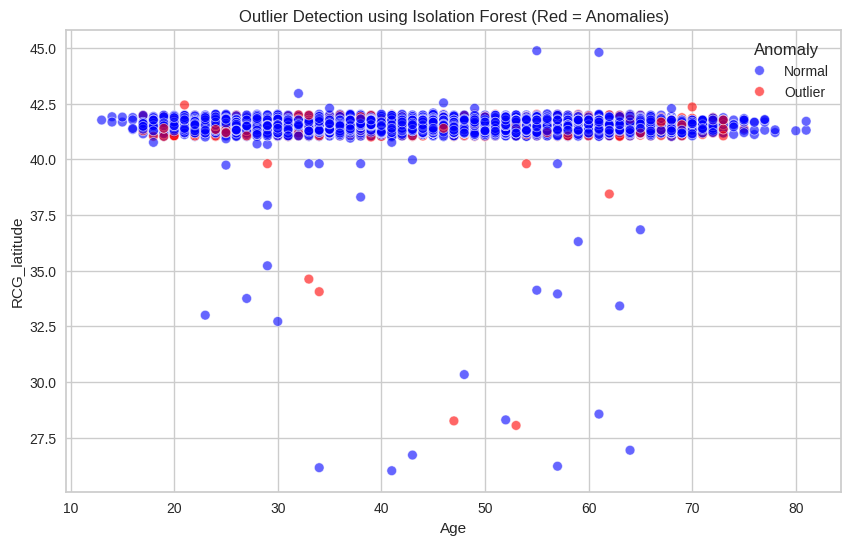

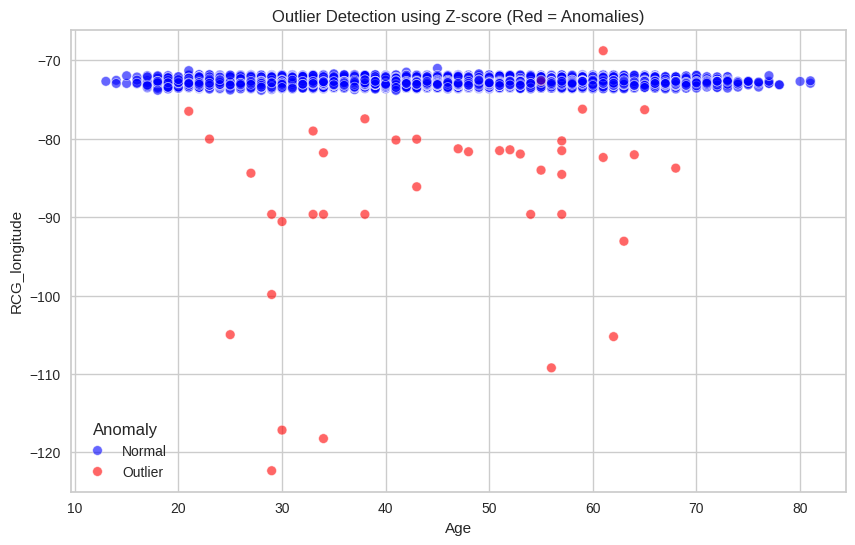

In [ ]:
# Function to plot outlier detection results
def plot_outliers(x, y, hue, title):
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=x, y=y, hue=hue, palette={0: 'blue', 1: 'red'}, alpha=0.6)
    plt.xlabel("Age")
    plt.ylabel(y.name)
    plt.title(title)
    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Normal", "Outlier"], title="Anomaly")
    plt.show()

# Plot Z-score and Isolation Forest results
plot_outliers(df_processed['Age'], df_processed['RCG_latitude'], df_processed['Anomaly_IF_Binary'],
              "Outlier Detection using Isolation Forest (Red = Anomalies)")

plot_outliers(df_processed['Age'], df_processed['RCG_longitude'], df_processed['Anomaly_Z_Binary'],
              "Outlier Detection using Z-score (Red = Anomalies)")

# Clustering

In [ ]:
# Copying dataset
df_clustering = df.copy()

In [ ]:
# Convert 'Yes'/'No' to binary (1/0)
for col in ["Fentanyl", "Cocaine", "Heroin", "Ethanol"]:
    df_clustering[col] = df_clustering[col].map({'Yes': 1, 'No': 0})

# Select relevant columns
columns = ["Age", "ICG_latitude", "ICG_longitude", "Fentanyl", "Cocaine", "Heroin", "Ethanol"]
df_clustering = df_clustering[columns]

# Drop rows with missing latitude/longitude (they are critical for clustering)
df_clustering.dropna(subset=["ICG_latitude", "ICG_longitude"], inplace=True)

# Impute missing age values with median
imputer = SimpleImputer(strategy="median")
df_clustering["Age"] = imputer.fit_transform(df_clustering[["Age"]])

# Impute missing drug values (replace NaN with 0, assuming no drug presence)
df_clustering[["Fentanyl", "Cocaine", "Heroin", "Ethanol"]] = df_clustering[["Fentanyl", "Cocaine", "Heroin", "Ethanol"]].fillna(0)

# Ensure no NaN remains
df_clustering.dropna(inplace=True)

# # Normalize numerical features, including drug columns
# scaler = StandardScaler()
# df_clustering[columns] = scaler.fit_transform(df_clustering[columns])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_clustering[columns])

<ipython-input-77-8250520332d5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering.dropna(subset=["ICG_latitude", "ICG_longitude"], inplace=True)
<ipython-input-77-8250520332d5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["Age"] = imputer.fit_transform(df_clustering[["Age"]])
<ipython-input-77-8250520332d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

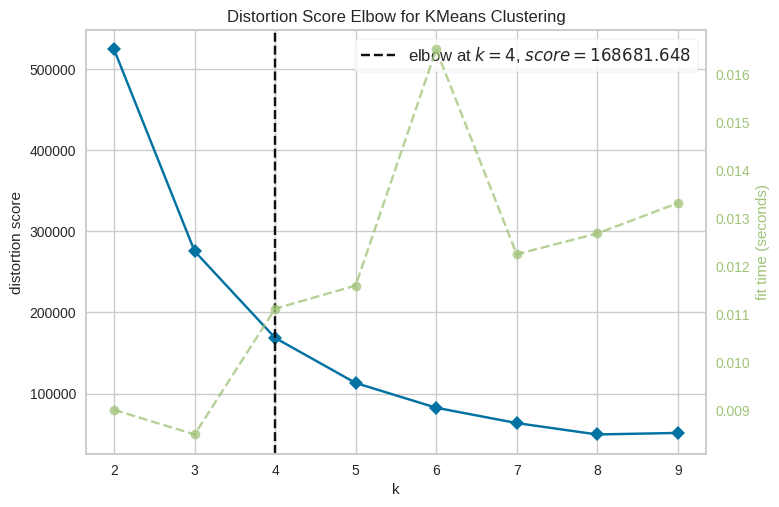

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:

# Step 1: Apply PCA (Dimensionality Reduction)
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_clustering)

# Step 2: Find Optimal Clusters using Elbow Method on PCA-transformed data
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2, 10))
visualizer.fit(df_pca)  # Use PCA-reduced features
visualizer.show()


In [ ]:
print(f"PCA Explained Variance: {sum(pca.explained_variance_ratio_)}")


PCA Explained Variance: 0.9965099529296662


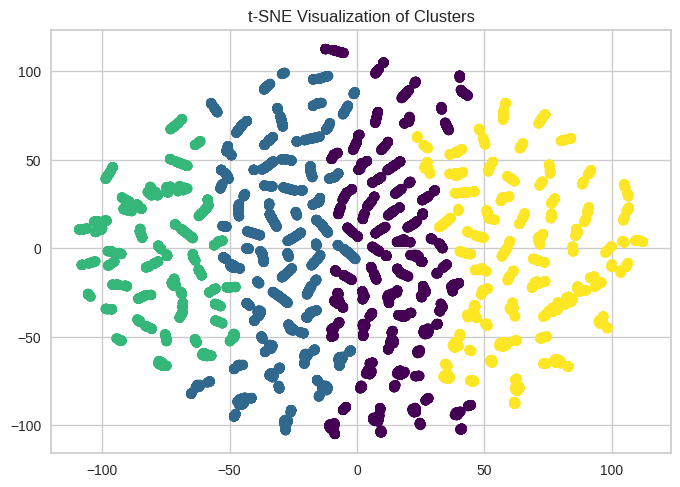

In [ ]:

# Step 3: Get optimal k value
optimal_k = visualizer.elbow_value_
if optimal_k is None:
    print("Warning: Elbow method did not find an optimal k, defaulting to k=3")
    optimal_k = 3

# Step 4: Apply K-Means Clustering on PCA-reduced data
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clustering['KMeans_Cluster'] = kmeans.fit_predict(df_pca)

# Step 5: Apply t-SNE for Visualization (on PCA output)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_tsne = tsne.fit_transform(df_pca)  # t-SNE on PCA-reduced data

# Step 6: Visualization using t-SNE
labels = df_clustering['KMeans_Cluster']
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=labels, cmap='viridis')
plt.title("t-SNE Visualization of Clusters")
plt.show()

In [ ]:
# Evaluate K-Means Clustering
# silhouette_kmeans = silhouette_score(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']], df_clustering['KMeans_Cluster'])
silhouette_kmeans = silhouette_score(df_pca, df_clustering['KMeans_Cluster'])

davies_bouldin_kmeans = davies_bouldin_score(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']], df_clustering['KMeans_Cluster'])
calinski_harabasz_kmeans = calinski_harabasz_score(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']], df_clustering['KMeans_Cluster'])

inertia_kmeans = kmeans.inertia_


print(f"K-Means Evaluation:\nSilhouette Score: {silhouette_kmeans}\nDavies-Bouldin Index: {davies_bouldin_kmeans}\nCalinski-Harabasz Index: {calinski_harabasz_kmeans}\nInertia: {inertia_kmeans}")


K-Means Evaluation:
Silhouette Score: 0.5219689394487746
Davies-Bouldin Index: 0.5873095457654534
Calinski-Harabasz Index: 38821.90039808403
Inertia: 168681.648385101


Cluster Centers:
Cluster 0: [3.66473379e+00 1.50571654e-03 2.29185458e-02]
Cluster 1: [-7.98478232  0.05909914 -0.01597287]
Cluster 2: [-1.82234723e+01 -6.64998971e-02  6.43431303e-03]
Cluster 3: [ 1.59289212e+01 -1.98897436e-02 -1.17919378e-02]


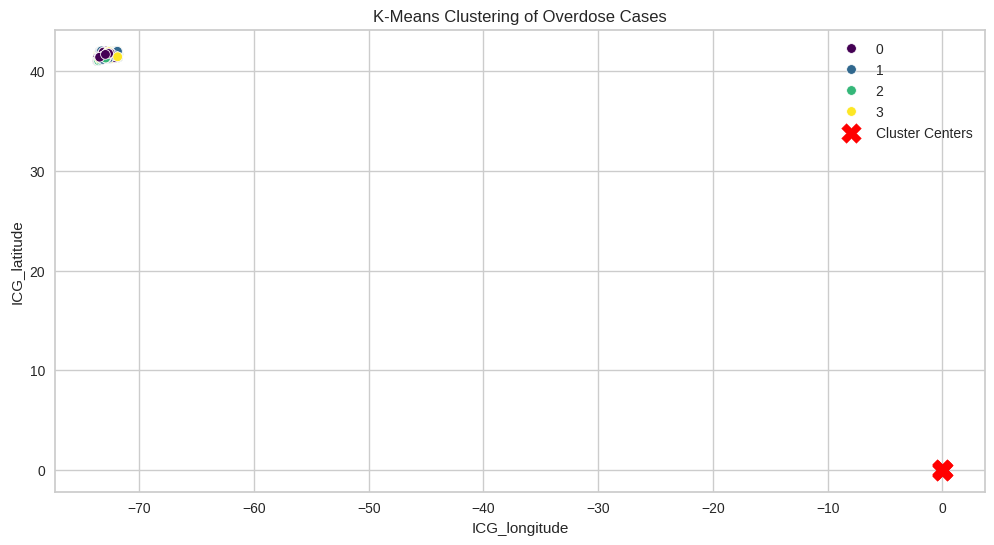

In [ ]:
# Get K-Means cluster centers
centers = kmeans.cluster_centers_

print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")


# Visualization - K-Means
plt.figure(figsize=(12,6))
sns.scatterplot(x=df_clustering['ICG_longitude'], y=df_clustering['ICG_latitude'], hue=df_clustering['KMeans_Cluster'], palette='viridis')
plt.scatter(centers[:, 2], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')  # Add cluster centers
plt.title('K-Means Clustering of Overdose Cases')
plt.legend()
plt.show()

In [ ]:
# # Determine optimal clusters using Elbow Method
# kmeans = KMeans()
# visualizer = KElbowVisualizer(kmeans, k=(2,10))
# visualizer.fit(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']])
# visualizer.show()

# # Ensure optimal_k is correctly assigned
# optimal_k = visualizer.elbow_value_

# if optimal_k is None:
#     print("Warning: Elbow method did not find an optimal k, defaulting to k=3")
#     optimal_k = 3

# # Apply K-Means clustering once
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# df_clustering['KMeans_Cluster'] = kmeans.fit_predict(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']])


In [ ]:
# # Apply K-Means clustering with exactly 5 clusters
# kmeans = KMeans(n_clusters=5, random_state=42)
# df_clustering['KMeans_Cluster'] = kmeans.fit_predict(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']])


In [ ]:
# pca = PCA(n_components=3)  # Reduce dimensions
# df_pca = pca.fit_transform(df_clustering)

# # Apply t-SNE on PCA output
# tsne = TSNE(n_components=2, perplexity=40, random_state=42)
# df_tsne = tsne.fit_transform(df_pca)

# # tsne = TSNE(n_components=2, perplexity=40, random_state=42)
# # # Replace df_scaled with df_clustering which contains the scaled data for clustering
# # df_tsne = tsne.fit_transform(df_clustering[['Age', 'ICG_latitude', 'ICG_longitude', 'Fentanyl', 'Cocaine', 'Heroin', 'Ethanol']])

# # Assuming 'labels' is meant to represent cluster assignments
# labels = df_clustering['KMeans_Cluster']

# plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=labels, cmap='viridis')
# plt.title("t-SNE Visualization of Clusters")
# plt.show()

KeyError: 'KMeans_Cluster'

# Clustering

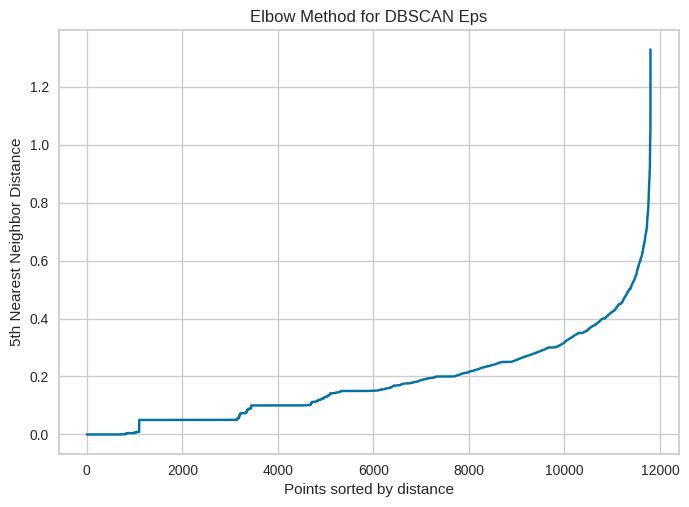

In [ ]:
# 1️⃣ Data Preprocessing
# Convert 'Yes'/'No' to binary (1/0)
drug_cols = ["Fentanyl", "Cocaine", "Heroin", "Ethanol"]
df_clustering[drug_cols] = df_clustering[drug_cols].replace({'Yes': 1, 'No': 0})

# Select relevant columns
columns = ["Age", "ICG_latitude", "ICG_longitude"] + drug_cols
df_clustering = df_clustering[columns].copy()

# Drop rows with missing latitude/longitude
df_clustering.dropna(subset=["ICG_latitude", "ICG_longitude"], inplace=True)

# Convert all columns to numeric, forcing non-numeric values to NaN
df_clustering = df_clustering.apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN values in essential columns
df_clustering.dropna(subset=["Age", "ICG_latitude", "ICG_longitude"], inplace=True)

# Impute missing values for Age using the median
imputer = SimpleImputer(strategy="median")
df_clustering["Age"] = imputer.fit_transform(df_clustering[["Age"]])

# Fill missing drug values with 0 (assuming missing means no presence)
df_clustering[drug_cols] = df_clustering[drug_cols].fillna(0)

#Combined DBSCAN Clustering (Location & Drug Usage)
features = ["Age", "ICG_latitude", "ICG_longitude"] + drug_cols
X = df_clustering[features]


# Convert all columns in X to numeric, replacing non-numeric values with NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Assuming df_clustering is your DataFrame with features for clustering
features = ["Age", "ICG_latitude", "ICG_longitude", "Fentanyl", "Cocaine", "Heroin", "Ethanol"]
X = df_clustering[features]

# Scale the features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X) # Defining X_scaled

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for DBSCAN Eps")
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=30)
df_clustering["DBSCAN_Cluster"] = dbscan.fit_predict(X_scaled)

# Evaluation
valid_clusters = df_clustering["DBSCAN_Cluster"] != -1
if valid_clusters.sum() > 1:
    silhouette = silhouette_score(X_scaled[valid_clusters], df_clustering["DBSCAN_Cluster"][valid_clusters])
    db_index = davies_bouldin_score(X_scaled[valid_clusters], df_clustering["DBSCAN_Cluster"][valid_clusters])
    print(f"DBSCAN Clustering - Silhouette Score: {silhouette:.4f}")
    print(f"DBSCAN Clustering - Davies-Bouldin Index: {db_index:.4f}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clustering["ICG_longitude"], y=df_clustering["ICG_latitude"], hue=df_clustering["DBSCAN_Cluster"], palette="viridis", edgecolor="k", alpha=0.6)
plt.xlabel("ICG_longitude")
plt.ylabel("ICG_latitude")
plt.title("DBSCAN Clustering - Combined Features")
plt.legend(title="Cluster ID")
plt.show()

In [ ]:
print(df_clustering["DBSCAN_Cluster"].value_counts())

In [ ]:
# 3️⃣ Results Analysis & Visualization
# Compute average drug usage per cluster
cluster_drug_usage = df_clustering.groupby("DBSCAN_Cluster")[drug_cols].mean()

# Visualize drug distribution per cluster
cluster_drug_usage.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Average Drug Usage Per DBSCAN Cluster")
plt.ylabel("Probability of Drug Presence")
plt.xlabel("DBSCAN Cluster ID")
plt.legend(title="Drug Type")
plt.show()

In [ ]:
# Display clustering results with drug usage intensity overlay
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_clustering["ICG_longitude"], df_clustering["ICG_latitude"],
                      c=df_clustering["DBSCAN_Cluster"], cmap="viridis", alpha=0.6, edgecolors="k")

size_factor = df_clustering[drug_cols].sum(axis=1) * 30  # Adjust point size
plt.scatter(df_clustering["ICG_longitude"], df_clustering["ICG_latitude"],
            s=size_factor, color="red", alpha=0.3, label="Drug Usage Intensity")

plt.xlabel("ICG_longitude")
plt.ylabel("ICG_latitude")
plt.title("DBSCAN Clustering - Drug Usage Intensity")
plt.legend()
plt.show()

In [ ]:
# 3️⃣ Drug Usage-Based DBSCAN Clustering
# Ensure all values are numeric
df_clustering = df_clustering.apply(pd.to_numeric, errors='coerce')

# Drop rows with non-numeric values
df_clustering.dropna(inplace=True)

# Compute total drug usage
df_clustering["Total_Drugs"] = df_clustering[drug_cols].sum(axis=1)

drug_features = ['Age'] + drug_cols
X_drug = df_clustering[drug_features]
X_scaled_drug = scaler.fit_transform(X_drug)

dbscan_drug = DBSCAN(eps=0.5, min_samples=30)
df_clustering["DBSCAN_Drug_Cluster"] = dbscan_drug.fit_predict(X_scaled_drug)

# Evaluation
valid_clusters_drug = df_clustering["DBSCAN_Drug_Cluster"] != -1
if valid_clusters_drug.sum() > 1:
    silhouette_drug = silhouette_score(X_scaled_drug[valid_clusters_drug], df_clustering["DBSCAN_Drug_Cluster"][valid_clusters_drug])
    db_index_drug = davies_bouldin_score(X_scaled_drug[valid_clusters_drug], df_clustering["DBSCAN_Drug_Cluster"][valid_clusters_drug])
    print(f"Drug-Based Clustering - Silhouette Score: {silhouette_drug:.4f}")
    print(f"Drug-Based Clustering - Davies-Bouldin Index: {db_index_drug:.4f}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clustering["Age"], y=df_clustering["Total_Drugs"], hue=df_clustering["DBSCAN_Drug_Cluster"], palette="coolwarm", edgecolor="k", alpha=0.6)
plt.xlabel("Age")
plt.ylabel("Drug Usage Intensity")
plt.title("DBSCAN Clustering Based on Drug Usage")
plt.legend(title="Cluster ID")
plt.show()

In [ ]:
print(df_clustering["DBSCAN_Drug_Cluster"].value_counts())